In [1]:
import requests
import pandas as pd
import json
import os
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from chembl_webresource_client.new_client import new_client

/home/florent/Programs/anaconda3/envs/py311/lib/python3.11/site-packages/chembl_webresource_client/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


In [3]:
assay = new_client.assay
activity = new_client.activity
molecule = new_client.molecule

#### Extract assay type A in Human

In [ ]:
batch_size = 20
offset = 0
max_records = 1000000  # or None for full
results = []
rawfile = "../data/raw/test_1M.csv"

while True:
    print(f"Fetching records {offset} to {offset + batch_size}...")
    
    batch = assay.filter(
        assay_type='A',
        assay_organism__iexact='Homo sapiens'
    ).only(['assay_type', 'description', 'assay_chembl_id', 'assay_organism'])[offset:offset + batch_size]

    if not batch:
        break

    df_batch = pd.DataFrame(batch)
    results.append(df_batch)

    offset += batch_size
    if max_records and offset >= max_records:
        break

    time.sleep(0.5)  # adjust delay if needed

if results:
    final_df = pd.concat(results, ignore_index=True)
    final_df.to_csv(rawfile, index=False)
    print(f"\n✅ Wrote {len(final_df)} records to {rawfile}")
else:
    print("\n⚠️ No data retrieved.")

#### Retrieve HLM activities

In [5]:
# filter HLM related terms only + get assays id
df = pd.read_csv('../data/raw/test_100k.csv')
pattern = re.compile(r'(?i)\b(?:HLM|human.*liver.*microsome|microsomal.*clearance|intrinsic.*clearance|metabolic.{0,3}stabil(?:ity|e))\b') # very specific
#pattern = r'(?i)\b(?:CL|microsome|HLM_CL|HLM_clearance|HLM_half_life|HLM_stability)\b' # more specific
hlm_df = df[df['description'].str.contains(pattern, na=False)]
hlm_assay_ids = hlm_df['assay_chembl_id'].tolist()
hlm_df.shape

(6952, 4)

In [ ]:
batch_size = 20  # API limit to avoid throttling
activities_file = "../data/staging/hlm_activities.csv"
first_batch = True
total_activities = 0

for i in range(0, len(hlm_assay_ids), batch_size):
    batch = hlm_assay_ids[i:i + batch_size]
    batch_num = i // batch_size + 1
    total_batches = (len(hlm_assay_ids) - 1) // batch_size + 1
    print(f"Fetching batch {batch_num} of {total_batches} ({len(batch)} assay IDs)")
    
    try:
        res = activity.filter(assay_chembl_id__in=batch).only([
            'molecule_chembl_id', 'assay_chembl_id',
            'standard_value', 'standard_units', 'standard_type',
            'standard_relation', 'document_chembl_id', 'description'
        ])
        
        if res:
            batch_df = pd.DataFrame(res)
            if first_batch:
                batch_df.to_csv(activities_file, mode='w', header=True, index=False)
                print(f"Created {activities_file} with {len(batch_df)} activities")
                first_batch = False
            else:
                batch_df.to_csv(activities_file, mode='a', header=False, index=False)
                print(f"Appended {len(batch_df)} activities")
            
            total_activities += len(batch_df)
            print(f"Total activities so far: {total_activities}")
        else:
            print("No activities found for this batch")
            
    except Exception as e:
        print(f"Error in batch {batch_num}: {e}")
        # Continue with next batch or implement retry logic
        continue
    
    time.sleep(1.0)  # Longer delay to avoid throttling

print(f"\n✅ Total activities retrieved: {total_activities}")

In [ ]:
# keep only CL for HLM values
filt = activities_df['standard_type'] == 'CL'
hlm_df = activities_df[filt]
hlm_df.to_csv('../data/staging/hlm_activities_CL.csv', index=False)
hlm_df.shape

#### DF exploration

In [29]:
hlm_df = pd.read_csv('../data/staging/hlm_activities_CL.csv')
print(f"Final dataset shape: {hlm_df.shape}")

Final dataset shape: (18424, 11)


In [30]:
hlm_df['document_chembl_id'].value_counts().head(2)

document_chembl_id
CHEMBL3301361    1510
CHEMBL4342426     138
Name: count, dtype: int64

In [31]:
hlm_df['assay_chembl_id'].value_counts().head(2)

assay_chembl_id
CHEMBL3301370    1102
CHEMBL3301372     408
Name: count, dtype: int64

In [32]:
# AZ data set: doc = CHEMBL3301361 = assay(CHEMBL3301370 + CHEMBL3301372)

In [ ]:
filt = hlm_df['assay_chembl_id'] == 'CHEMBL3301370'
hlm_df = hlm_df[filt]
hlm_df

#### Retrieve molecules from subset

In [16]:
unique_molecule_ids = hlm_df['molecule_chembl_id'].unique().tolist()
len(hlm_df)

1510

In [18]:
import requests
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Optional

def get_smiles_via_rest_optimized(chembl_id: str) -> Dict[str, Optional[str]]:
    """Optimized single request function"""
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}.json"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json()
            smiles = data.get('molecule_structures', {}).get('canonical_smiles')
            return {'molecule_chembl_id': chembl_id, 'canonical_smiles': smiles}
    except Exception as e:
        print(f"REST API error for {chembl_id}: {e}")
    
    return {'molecule_chembl_id': chembl_id, 'canonical_smiles': None}

def get_smiles_parallel(chembl_ids: List[str], max_workers: int = 5) -> pd.DataFrame:
    """Use ThreadPoolExecutor for parallel requests within a chunk"""
    results = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all requests
        future_to_id = {
            executor.submit(get_smiles_via_rest_optimized, mol_id): mol_id 
            for mol_id in chembl_ids
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_id):
            result = future.result()
            results.append(result)
            time.sleep(0.05)  # Small delay between processing results
    
    return pd.DataFrame(results)

def get_smiles_chunked_parallel(unique_molecule_ids: List[str], 
                               chunk_size: int = 100, 
                               max_workers: int = 5) -> pd.DataFrame:
    """
    Process in chunks with parallel requests within each chunk
    Best balance of speed and API courtesy
    """
    all_results = []
    
    for i in range(0, len(unique_molecule_ids), chunk_size):
        chunk = unique_molecule_ids[i:i + chunk_size]
        chunk_num = i//chunk_size + 1
        total_chunks = (len(unique_molecule_ids)-1)//chunk_size + 1
        
        print(f"Processing chunk {chunk_num}/{total_chunks} ({len(chunk)} molecules)")
        
        chunk_df = get_smiles_parallel(chunk, max_workers=max_workers)
        all_results.append(chunk_df)
        
        # Longer pause between chunks to be respectful to the API
        if i + chunk_size < len(unique_molecule_ids):
            print(f"Completed chunk {chunk_num}, pausing before next chunk...")
            time.sleep(2)
    
    return pd.concat(all_results, ignore_index=True)

In [ ]:
%%time
print("Starting chunked parallel SMILES retrieval...")
smiles_df = get_smiles_chunked_parallel(unique_molecule_ids, chunk_size=20, max_workers=5)
print(f"Retrieved {len(smiles_df)} records total")

In [21]:
smiles_df.to_csv('../data/staging/hlm_activities_CL_smi.csv', index=False)

#### Merge all datasets

In [13]:
smiles_df = pd.read_csv('../data/staging/hlm_activities_CL_smi.csv')

In [14]:
merged_df = hlm_df.merge(
    smiles_df, 
    on='molecule_chembl_id', 
    how='left'  # Keep all activities, even if no SMILES found
)

In [15]:
merged_df['standard_units'].value_counts()

standard_units
mL.min-1.g-1              1102
uL.min-1.(10^6cells)-1     408
Name: count, dtype: int64

In [20]:
filt = merged_df['assay_chembl_id'] == 'CHEMBL3301370'
df = merged_df[filt]

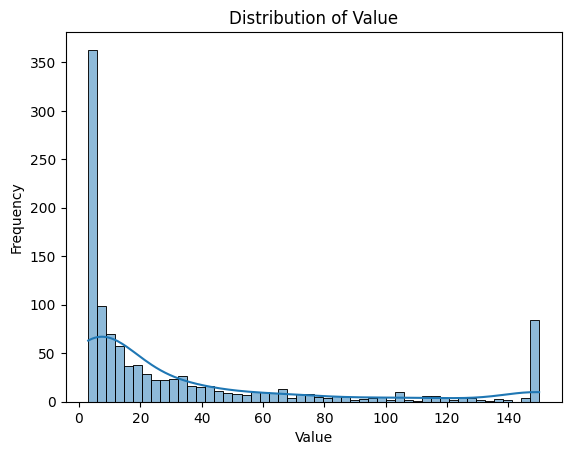

In [35]:
sns.histplot(df['value'].dropna(), bins=50, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Value')
plt.show()

#### Analysis + Plot

In [22]:
df.columns

Index(['assay_chembl_id', 'document_chembl_id', 'molecule_chembl_id',
       'relation', 'standard_relation', 'standard_type', 'standard_units',
       'standard_value', 'type', 'units', 'value', 'canonical_smiles'],
      dtype='object')

In [26]:
df['standard_type'].value_counts().head(29)

standard_type
CL    1102
Name: count, dtype: int64

In [27]:
filt = df['standard_type'] == 'CL'
df[filt]

,assay_chembl_id,document_chembl_id,molecule_chembl_id,relation,standard_relation,standard_type,standard_units,standard_value,type,units,value,canonical_smiles
0,CHEMBL3301370,CHEMBL3301361,CHEMBL1164729,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O
1,CHEMBL3301370,CHEMBL3301361,CHEMBL62136,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...
2,CHEMBL3301370,CHEMBL3301361,CHEMBL1071,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1
3,CHEMBL3301370,CHEMBL3301361,CHEMBL1526762,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,Cc1cc(C)nc(SCC(N)=O)n1
4,CHEMBL3301370,CHEMBL3301361,CHEMBL9967,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,CN1CCN(CC(=O)N2c3ccccc3C(=O)Nc3cccnc32)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...
1505,CHEMBL3301370,CHEMBL3301361,CHEMBL1779503,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,O=C(NCCc1ccccc1)c1cc(-n2ncc(=O)[nH]c2=O)ccc1Cl
1506,CHEMBL3301370,CHEMBL3301361,CHEMBL550436,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,C[C@H](CO)n1ccc2c(NC(=O)Cc3ccc(Cl)c(C(F)(F)F)c...
1507,CHEMBL3301370,CHEMBL3301361,CHEMBL2324355,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,Cc1nocc1C(=O)Nc1ccc(-c2ccccc2OC(F)(F)F)c(N)n1
1508,CHEMBL3301370,CHEMBL3301361,CHEMBL192307,<,<,CL,mL.min-1.g-1,3.0,CLint,microL/min/mg,3.0,CCCCc1nc2c(N)nc3ccccc3c2n1CC(C)C


In [ ]:
tmp['document_chembl_id'].value_counts().head(3)

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(full_data, x='standard_type')
plt.xticks(rotation=45, ha='right')

In [ ]:
%%time
# 10k = 98s
assays = assay.filter(
    assay_type='A',
    assay_organism__iexact='Homo sapiens'
).only(['assay_type', 'description', 'assay_chembl_id', 'assay_organism'])[:10000]
df = pd.DataFrame(assays)

#### Filter subset

In [ ]:
filt = activities_df['standard_type'] == 'CL'
tmp = activities_df[filt]

In [ ]:
filt = activities_df['document_chembl_id'] == 'CHEMBL4342426'
tmp = activities_df[filt]

In [ ]:
tmp.head(5)

#### Look at molecules

In [ ]:
full_data['mol_smi'] = full_data['molecule_structures'].apply(lambda x: x.get('canonical_smiles') if isinstance(x, dict) else None)

In [ ]:
PandasTools.AddMoleculeColumnToFrame(
    tmp, 
    smilesCol='mol_smi',  # Column containing SMILES strings
    molCol='Molecule',             # Name of new column to create
    includeFingerprints=False      # Set to True if you need fingerprints
)

#### Extract hERG

In [ ]:
from chembl_webresource_client.new_client import new_client

target = new_client.target
activity = new_client.activity
herg = target.filter(pref_name__iexact='hERG').only('target_chembl_id')[0]
herg_activities = activity.filter(target_chembl_id=herg['target_chembl_id']).filter(standard_type="IC50")

herg_activities

#### Extract HLM data

In [ ]:
def fetch_metabolic_assays(limit=1000):
    url = f"https://www.ebi.ac.uk/chembl/api/data/assay.json?assay_type=ADME&limit={limit}"
    assays = []
    while url:
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        for a in data["assays"]:
            if "metabolic" in (a.get("description") or "").lower():
                assays.append(a["assay_chembl_id"])
        url = data["page_meta"]["next"]
    return assays

def fetch_activities_for_assays(assay_ids, limit=1000):
    activities = []
    for assay_id in assay_ids:
        url = f"https://www.ebi.ac.uk/chembl/api/data/activity.json?assay_chembl_id={assay_id}&limit={limit}"
        while url:
            res = requests.get(url)
            res.raise_for_status()
            data = res.json()
            activities.extend(data["activities"])
            url = data["page_meta"]["next"]
    return activities

In [ ]:
assay_ids = fetch_metabolic_assays()
print(f"Found {len(assay_ids)} assays likely related to metabolic stability.")

activities = fetch_activities_for_assays(assay_ids[:5])  # You can increase the slice
print(f"Retrieved {len(activities)} activity records.")

In [ ]:
def fetch_molecules_with_logp_and_docs(limit=100, max_pages=None, verbose=True):
    url = f"{base_url}/chembl/api/data/molecule.json?logp__isnull=false&molecule_documents__isnull=false&limit={limit}"
    molecules = []
    page = 0
    
    while url and (max_pages is None or page < max_pages):
        if verbose:
            print(f"Fetching page {page + 1}...")
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        molecules.extend(data['molecules'])

        next_url = data['page_meta']['next']
        url = f"{base_url}{next_url}" if next_url else None
        page += 1

    return molecules

In [ ]:
molecules = fetch_molecules_with_logp_and_docs(limit=50, max_pages=1)

with open("../data/raw/chembl_logP_molecules.json", "w") as f:
    json.dump(molecules, f, indent=2)

print(f"Fetched {len(molecules)} molecules with logP.")

In [ ]:
df = pd.DataFrame(molecules)
df.columns

In [ ]:
df = df[['molecule_structures', 'molecule_chembl_id', 'molecule_properties']]
df.head(2)

In [ ]:
# Test API with a known molecule Chembl ID
chembl_id = "CHEMBL6329"
url = f"https://www.ebi.ac.uk/chembl/api/data/document.json?molecule_chembl_id={chembl_id}"
res = requests.get(url)
res.raise_for_status()
data = res.json()
documents = data.get("documents", [])
df = pd.DataFrame(documents)
df.head(1)

In [ ]:
# Get all activities in CHemBL 
url = "https://www.ebi.ac.uk/chembl/api/data/activity.json?limit=1000"
res = requests.get(url)
res.raise_for_status()
data = res.json()

types = {a["standard_type"] for a in data["activities"] if a.get("standard_type")}
types = sorted(types)
for t in types:
    print(t)

#### Get document_id for subset

In [ ]:
# Function to fetch documents associated with a molecule
def get_documents_for_molecule(chembl_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/document.json?molecule_chembl_id={chembl_id}"
    res = requests.get(url)
    res.raise_for_status()
    return res.json().get("documents", [])

In [ ]:
chembl_id = "CHEMBL25"
documents = get_documents_for_molecule(chembl_id)
documents

In [ ]:
# Add document IDs to each molecule
def fetch_documents_for_molecules(molecules):
    doc_map = {}
    for mol in molecules:
        chembl_id = mol.get("molecule_chembl_id")
        if chembl_id:
            docs = get_documents_for_molecule(chembl_id)
            doc_ids = [d["document_chembl_id"] for d in docs]
            doc_map[chembl_id] = doc_ids
    return doc_map

In [ ]:
doc_map = fetch_documents_for_molecules(molecules)

In [ ]:
doc_map

In [ ]:
df = pd.DataFrame(molecules)

In [ ]:
df["logP"] = df["molecule_properties"].apply(
    lambda x: x.get("alogp") if isinstance(x, dict) else None
)

In [ ]:
df["document_ids"] = df["molecule_chembl_id"].map(doc_map)

# Show merged DataFrame
df_merged = df[["molecule_chembl_id", "logP", "document_ids"]]
print(df_merged.head())

#### Get molecules from document_id

In [ ]:
def get_molecules_for_document(document_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule_document.json?document_chembl_id={document_id}"
    res = requests.get(url)
    res.raise_for_status()
    return res.json().get("molecule_documents", [])

In [ ]:
# Example: Get molecules associated with a document
document_id = "CHEMBL1158643"
molecule_docs = get_molecules_for_document(document_id)

# Print out the molecule ChEMBL IDs
molecule_ids = [doc["molecule_chembl_id"] for doc in molecule_docs]
print(f"Molecule ChEMBL IDs for document {document_id}: {molecule_ids}")

In [ ]:
def fetch_molecules_with_logp_and_patents(limit=100, max_pages=None, verbose=True):
    base_url = "https://www.ebi.ac.uk"
    url = f"{base_url}/chembl/api/data/molecule.json?logp__isnull=false&molecule_patents__isnull=false&limit={limit}"
    molecules = []
    page = 0

    while url and (max_pages is None or page < max_pages):
        if verbose:
            print(f"Fetching page {page + 1}...")
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        molecules.extend(data['molecules'])

        next_url = data['page_meta'].get('next')
        url = f"{base_url}{next_url}" if next_url else None
        page += 1

    return molecules

def fetch_molecules_with_logp_smiles_and_patents(limit=100, max_pages=None, verbose=True):
    base_url = "https://www.ebi.ac.uk"
    url = f"{base_url}/chembl/api/data/molecule.json?logp__isnull=false&molecule_patents__isnull=false&limit={limit}"
    molecules = []
    page = 0

    while url and (max_pages is None or page < max_pages):
        if verbose:
            print(f"Fetching page {page + 1}...")
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        molecules.extend(data['molecules'])

        next_url = data['page_meta'].get('next')
        url = f"{base_url}{next_url}" if next_url else None
        page += 1

    # Fetch SMILES and Patent IDs for each molecule
    molecules_with_smiles_and_patents = []
    for molecule in molecules:
        patent_ids = []
        smiles = None
        
        # Get SMILES from molecule_structures
        if 'molecule_structures' in molecule:
            smiles = molecule['molecule_structures'].get('canonical_smiles', None)
        
        # Get patent IDs from molecule_patents
        if 'molecule_patents' in molecule:
            patent_ids = [patent['patent_chembl_id'] for patent in molecule['molecule_patents']]
        
        # Add SMILES and patent IDs to molecule data
        molecule['smiles'] = smiles
        molecule['patent_ids'] = patent_ids
        molecules_with_smiles_and_patents.append(molecule)

    return molecules_with_smiles_and_patents